In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Import libraries**

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
import keras_preprocessing
from keras_preprocessing import image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import optimizers
from tensorflow.keras.optimizers import Adam
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import keras
from keras.utils.np_utils import to_categorical
import cv2
from keras.layers import Dense, GlobalAveragePooling2D
from keras_preprocessing.image import ImageDataGenerator
from keras import callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.layers import  Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import Xception
from keras.models import Model, Input

In [ ]:
%cd /content/gdrive/"My Drive"/"Covid19"

/content/gdrive/My Drive/Covid19


**Fetch the dataset**

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Covid19"

**Split the dataset into train and test data**

In [ ]:
disease_types=['COVID', 'non-COVID']
Data_dir = '/content/gdrive/MyDrive/cv_project/Covid19'
train_set_dir = os.path.join(Data_dir)

In [ ]:
train_set_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_set_dir, sp)):
        train_set_data.append(['{}/{}'.format(sp, file), defects_id, sp])
train_set = pd.DataFrame(train_set_data, columns=['File', 'DiseaseID','Disease Type'])

In [ ]:
Img_size = 64
def read_image(file_path):
    return cv2.imread(os.path.join(Data_dir, file_path)) 
def resize_image(image, Img_size):
    return cv2.resize(image.copy(), Img_size, interpolation=cv2.INTER_AREA)

In [ ]:
X_train_set = np.zeros((train_set.shape[0], Img_size, Img_size, 3))
for i, file in tqdm(enumerate(train_set['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train_set[i] = resize_image(image, (Img_size, Img_size))
X_train_set = X_train_set / 255.
print(X_train_set.shape)

2481it [09:12,  4.49it/s]


(2481, 64, 64, 3)


In [ ]:
Y_train_set = train_set['DiseaseID'].values
Y_train_set = to_categorical(Y_train_set, num_classes=2)

In [ ]:
X_train_set, X_value, Y_train_set, Y_value = train_test_split(X_train_set, Y_train_set, test_size=0.2, random_state = 42)

**Define the Xcepetion model**

In [ ]:
BATCH_SIZE = 64
Epochs = 50
Size=64
N_CH=3

In [ ]:
xception_Model = Xception(weights='imagenet', include_top=False)

input = Input(shape=(Size, Size, N_CH))
x = Conv2D(3, (3, 3), padding='same')(input)
    
x = xception_Model(x)
    
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# multi output
output = Dense(2,activation = 'softmax', name='root')(x)
 

# Model
Model = Model(input,output)
    
optimizer = Adam(learning_rate=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
Model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
Model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 3)         84        
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                              

**Train the model**

In [ ]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('Xception_Model.hdf5', verbose=1, save_best_only=True)
data_generator = ImageDataGenerator(rotation_range=360, 
                        width_shift_range=0.2, 
                        height_shift_range=0.2,
                        zoom_range=0.2, 
                        horizontal_flip=True, 
                        vertical_flip=True) 

data_generator.fit(X_train_set)

In [ ]:
history = Model.fit(data_generator.flow(X_train_set, Y_train_set, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train_set.shape[0] // BATCH_SIZE,
               epochs=Epochs,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_value, Y_value))

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 1.2460 - accuracy: 0.5055
Epoch 00001: val_loss improved from inf to 0.65436, saving model to Xception_Model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


31/31 [==============================] - 254s 8s/step - loss: 1.2460 - accuracy: 0.5055 - val_loss: 0.6544 - val_accuracy: 0.6539 - lr: 0.0030
Epoch 2/50
31/31 [==============================] - ETA: 0s - loss: 1.0480 - accuracy: 0.5252
Epoch 00002: val_loss did not improve from 0.65436
31/31 [==============================] - 244s 8s/step - loss: 1.0480 - accuracy: 0.5252 - val_loss: 0.6996 - val_accuracy: 0.4889 - lr: 0.0030
Epoch 3/50
31/31 [==============================] - ETA: 0s - loss: 0.9325 - accuracy: 0.5287
Epoch 00003: val_loss did not improve from 0.65436
31/31 [==============================] - 243s 8s/step - loss: 0.9325 - accuracy: 0.5287 - val_loss: 0.6934 - val_accuracy: 0.4849 - lr: 0.0030
Epoch 4/50
31/31 [==============================] - ETA: 0s - loss: 0.7903 - accuracy: 0.5852
Epoch 00004: val_loss did not improve from 0.65436
31/31 [==============================] - 244s 8s/step - loss: 0.7903 - accuracy: 0.5852 - val_loss: 0.6794 - val_accuracy: 0.5855 - lr: 

**Plot the results**

In [ ]:
Accuracy = history.history['accuracy']
Val_accuracy = history.history['val_accuracy']
Loss = history.history['loss']
Validation_loss = history.history['val_loss']

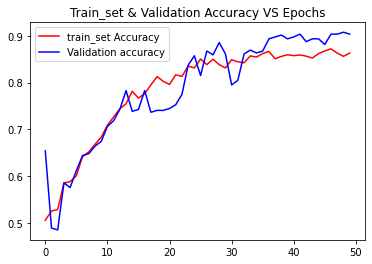

<Figure size 432x288 with 0 Axes>

In [ ]:
Epochs = range(len(Accuracy))
plt.plot(Epochs, Accuracy, 'r', label='train_set Accuracy')
plt.plot(Epochs, Val_accuracy, 'b', label='Validation accuracy')
plt.title('Train_set & Validation Accuracy VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

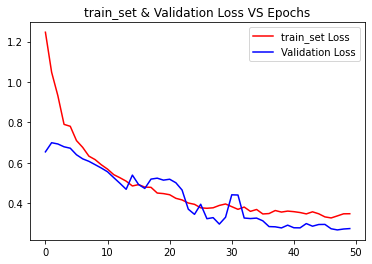

<Figure size 432x288 with 0 Axes>

In [ ]:
Epochs = range(len(Accuracy))
plt.plot(Epochs, Loss, 'r', label='train_set Loss')
plt.plot(Epochs, Validation_loss, 'b', label='Validation Loss')
plt.title('train_set & Validation Loss VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
Model.load_weights("Xception_Model.hdf5")
score = Model.evaluate(X_value, Y_value ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

16/16 [==============================] - 8s 474ms/step - loss: 0.2683 - accuracy: 0.9034
Test Loss: 0.26827535033226013
Test accuracy: 90.34205079078674


Text(0.5, 1.0, 'Confusion Matrix')

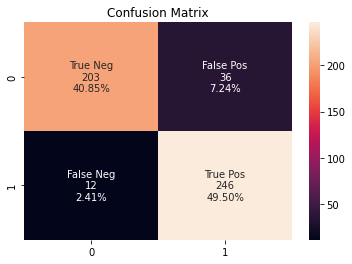

In [ ]:
Y_predict = Model.predict(X_value)
Y_predictx = np.argmax(Y_predict, axis = -1)
Y_valuex = np.argmax(Y_value, axis = -1)
cf_matrix = confusion_matrix(Y_valuex, Y_predictx)
group_name = ['True Neg','False Pos','False Neg','True Pos']
group_count = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentage = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
label = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_name,group_count,group_percentage)]
label = np.asarray(label).reshape(2,2)
sns.heatmap(cf_matrix, annot = label, fmt = '')
plt.title("Confusion Matrix")